# 20180829

Setup:

Agents, speakers and listeners

$A = \{S, L\}$

Set of meanigns (objects in the world).

$M = \{m_1, m_2, .., m_n\}$

Set of utterances.

$U = \{u_1, u_2, .., u_m\}$

Set of languages (semantic mappings)

$L = \{\ell_1, \ell_2, ..., \ell_k\}$

Set of contexts in which meanings occur.

$C = \wp(M) $


Measure of language efficiency:

$$H_{\ell\in L}{\text{cross}}(S_k, L_k) = \sum_{u, m}P_S(u, m)log_2(P_L(u,m))$$
where
$$P_S(u, m) = S_k(u|m)p(m)$$
$$P_L(u, m) = L_k(m|u)p(u)$$

# Claims

* **Claim 0:** More pragmatics is more efficient given system $\ell$.
* **Claim 1:** Pragmatic agents will prefer more efficient systems (minimizing the speaker-listener cross-entropy). Note, this needs support in `webppl`.
* **Claim 2:** Pragmatic agents will prefer ambiguous items *when* they can be disambiguated in context if languages are chosen according the cross entropy loss. 
* **Claim 3:** 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import tqdm
# Import custom utils
sys.path.append(os.path.join(os.path.abspath(os.getcwd()), '..', 'optimizing_design'))
from utils import *

## **Claim 0:** More pragmatics is more efficient given system $\ell$.

Given language $\ell$ a pair of $H_{\ell}(S_k, L_k) \leq H_{\ell}(S_{k-1}, L_{k-1}) \leq ... \leq H_{\ell}(S_0, L_0)$. That is, pragmatic communicators using system $\ell$ are always at least as efficient as "less" pragmatic interlocutors.

Note this claim should be supported by Pat Shafto ["Optimal Cooperative Inference" ](https://arxiv.org/abs/1705.08971)

In [2]:
meanings = ['h', 'g', 'm', 'hg', 'hm', 'gm', 'hgm']
utterances = ['h', 'g', 'm', 'hg', 'hm', 'gm', 'hgm']

In [3]:
M = create_boolean_matrix(meanings, utterances)
max_depth = 50
n_sims = 100
res = []
seen_contexts = set()
for i in tqdm.tqdm(range(n_sims)):
    # Vary context size (number of objects)
    context_size = np.random.choice(range(1, len(meanings)), 1)[0]
    # Select context composition (objects to include)
    slice_ = to_array(set(np.random.choice(range(len(meanings)), context_size, replace=False)))
    context_str = ''.join(['{}']*len(slice_))
    context_str = context_str.format(*slice_) 

    # Check if we've seen this context before
    while context_str in seen_contexts:
        context_size = np.random.choice(range(1, len(meanings)), 1)[0]
        slice_ = to_array(np.random.choice(range(len(meanings)), context_size, replace=False))
        context_str = ''.join(['{}']*len(slice_))
        context_str = context_str.format(*slice_)

    # Create boolean matrix
    M_current = column_slice(M, slice_)
    
    # Uniform priors over meanings and utterances.
    Us = np.array([1. for _ in range(M_current.shape[0])])
    Ms = np.array([1. for _ in range(M_current.shape[1])])
    p_u = Us / np.sum(Us)  # Uniform over utterances
    p_u = np.array(p_u)
    p_m = Ms / np.sum(Ms)  # Uniform over meanings
    p_m = np.array(p_m)
    speakers = []
    listeners = []
    curr_data = []
    for d in range(-1, max_depth):
        S_ = normalize(rsa_speaker(M_current, d+1) * p_m)
        L_ = normalize((rsa_listener(M_current, d+1).transpose() * p_u).transpose())
        CE = crossEntropy(S_, L_)
        curr_data.append(('CE{}'.format(d), CE))
    curr_data.extend([("context_size", context_size), ("context", context_str)])
    res.append({k:v for k, v in curr_data})
    seen_contexts.add(context_str)
    
df_res = pd.DataFrame(res)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/benpeloquin/Desktop/Projects/uid_rsa_conversations/rsa_efficiency/../optimizing_design/utils.py:78: RuntimeWarning: invalid value encountered in divide
  return np.nan_to_num((M.transpose() / row_totals).transpose())
100%|██████████| 100/100 [00:18<00:00,  5.28it/s]


Prep for plotting

In [4]:
model_nums = range(max_depth)    
models = ['CE{}'.format(d) for d in model_nums]
max_model = models[-1]
df_res = df_res.sort_values(by=max_model)

Text(0.5,1,'Theorem 0: CE(k order) <= CE(k-1 order)')

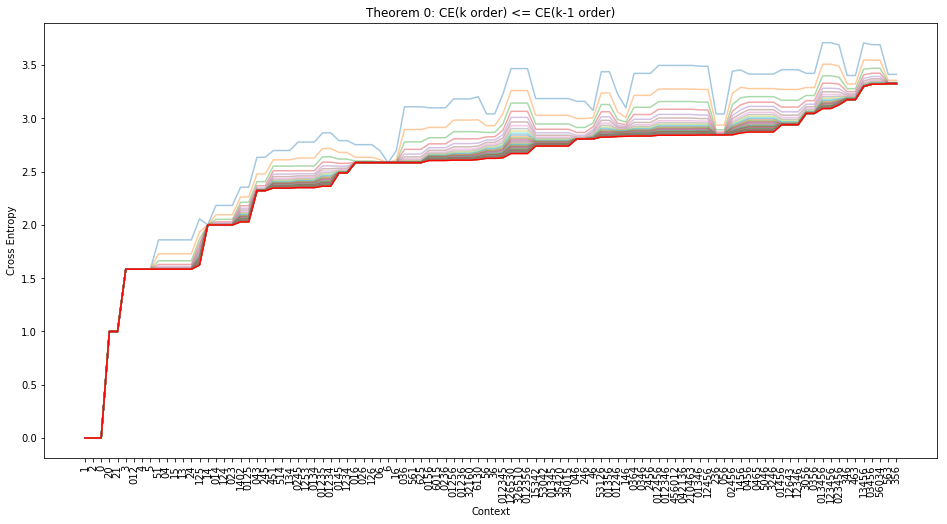

In [5]:

plt.figure(figsize=(16,8))
plt.xticks(rotation=90)
for model in models:
    if model == max_model:
        plt.plot(df_res['context'].values, df_res[model].values, alpha=0.95, c='red', markersize=20)
    else:
        plt.plot(df_res['context'].values, df_res[model].values, alpha=0.4, markersize=12)
plt.ylabel("Cross Entropy")
plt.xlabel("Context")
plt.title("Theorem 0: CE(k order) <= CE(k-1 order)")


## **Claim 1:** Pragmatic agents will prefer more efficient systems (minimizing the speaker-listener cross-entropy).

$$argmin_{\ell \in L}H_{\ell}(S_k, L_k)$$

### Simple example - single context, all objects have some mapping

In [6]:
n_utterances, n_meanings = 4, 4

def simple_filter(M):
    return all(np.sum(M, axis=0)==1)
simple_languages = generate_languages(n_utterances, n_meanings, simple_filter)

In [7]:
depth = 0
p_m = [0.5, 0.3, 0.15, 0.05]
p_u = [0.5, 0.3, 0.15, 0.05]

res = []
for M, name in simple_languages:
    S0 = normalize(rsa_speaker(M, depth) * p_m)
    L0 = normalize((rsa_listener(M, depth).transpose() * p_u).transpose())
    res.append((name, crossEntropy(S0, L0)))
res = sorted(res, key=lambda x: x[1])    

for idxs, CE in res[:3]:
    print("=====")
    print(idxs)
    print(CE)
    print(create_semantics_M(idxs, n_utterances, n_meanings))

=====
(0, 5, 10, 15)
1.647730922119161
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
=====
(0, 5, 10, 11)
1.6944822156393262
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 1.]
 [0. 0. 0. 0.]]
=====
(0, 1, 10, 15)
1.7120680710395408
[[1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Here $\ell=(0, 4, 8)$

## **Claim 2:** Pragmatic agents will prefer ambiguous items *when* they can be disambiguated in context if languages are chosen according the cross entropy loss. 

### Less simple example - multiple contexts

In [8]:
depth = 1
p_m_1 = [0.5, 0.3, 0.15, 0.05]
p_m_2 = [0.3, 0.5, 0.15, 0.05]
p_m_3 = [0.3, 0.15, 0.5, 0.05]
contexts = [p_m_1, p_m_2, p_m_3]
p_u = [0.5, 0.3, 0.15, 0.05]
p_c = 1 / float(len(contexts))

res = []
for M, name in simple_languages:
    S0_1 = normalize(rsa_speaker(M, depth) * contexts[0])
    S0_2 = normalize(rsa_speaker(M, depth) * contexts[1])
    S0_3 = normalize(rsa_speaker(M, depth) * contexts[2])
    L0 = normalize((rsa_listener(M, depth).transpose() * p_u).transpose())
    
    res.append((name, crossEntropy(S0_1, L0)*p_c \
                + crossEntropy(S0_2, L0)*p_c \
                + crossEntropy(S0_3, L0)*p_c))
res = sorted(res, key=lambda x: x[1])    

for idxs, CE in res[:3]:
    print("=====")
    print(idxs)
    print(CE)
    print(create_semantics_M(idxs, n_utterances, n_meanings))

=====
(1, 2, 4, 15)
1.7851852023016206
[[0. 1. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]
=====
(0, 1, 10, 15)
1.7980473903589316
[[1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
=====
(0, 2, 5, 15)
1.7983369225933101
[[1. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 1.]]
